# Word3Vec (11th November 2021)

This notebook applies word2vec to the corpus of tribunal decisions.

In particular, the notebook does:

1. Data preparation for word2vec.

2. Implementation of word2vec.

3. Topic model with Latent Dirichlet Allocation (LDA) and Latent Semantic Indexing (LSI).

4. Key word extraction

The resulting trained model is... .

This notebook should run in the tfm environment, which can be created with the environment.yml file.

In [1]:
from os import listdir
from os.path import isfile, join, getsize
import numpy as np

import time
import re
import json
import pickle
import pandas as pd
import whois
import sys
import datetime
from tqdm import tqdm
import textract
import gensim
import spacy
import scipy as sp
import sys
import multiprocessing
import gensim
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import remove_stopwords

import logging

from smart_open import smart_open
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

from collections import defaultdict  # For word frequency


# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)



IN_COLAB = 'google.colab' in sys.modules


# What environment am I using?
print(f'Current environment: {sys.executable}')

# Change the current working directory
os.chdir('/Users/albertamurgopacheco/Documents/GitHub/TFM')
# What's my working directory?
print(f'Current working directory: {os.getcwd()}')


Current environment: /Users/albertamurgopacheco/anaconda3/envs/tfm/bin/python
Current working directory: /Users/albertamurgopacheco/Documents/GitHub/TFM


/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Define working directories in colab and local execution

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    docs_path = '/content/gdrive/MyDrive/TFM/data/raw'
    input_path = '/content/gdrive/MyDrive/TFM'
    output_path = '/content/gdrive/MyDrive/TFM/output'

else:
    docs_path = './data/raw'
    input_path = '.'
    output_path = './output'

# WORD2VEC

# 1. The data preparation

Loading the data to a list of documents (corpus) where each document is a judicial decision.

In [ ]:
# Open jsonDataFinal file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# List to store the judicial decisions
corpus = []

corruptFiles = ['HU077022015', 'HU029682017']

# Search data list of dictionaries for dict where {"File":} = file_name
for d in tqdm(data):
    # Dealing with corrupt and empty files
    if d.get('File') not in corruptFiles:
        doc = d.get('String')
        if doc:
            corpus.append(doc)
        else:
            continue

print(f'The corpus includes {len(corpus)} documents.')
print(f'The documents are {type(corpus[0])}.')

Cleaning each document

In [ ]:
# Gensim-implemented filters for preprocessing data
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, 
strip_multiple_whitespaces, strip_non_alphanum, strip_numeric, remove_stopwords]

# List storing the preprocessed documents
corpus_clean = [preprocess_string(doc, CUSTOM_FILTERS) for doc in corpus]

# Removing non-numerical characters
#brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in corpus_clean)

In [ ]:
# Number of available processing cores
cores = multiprocessing.cpu_count()
print(f'Available cores {cores}.')

Lemmatizing and removing the stopwords and non-alphabetic characters.

In [ ]:
# IF RAN, DO IT BEFORE CLEANING... 

import spacy
#nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
#nlp = spacy.load('en_core_web_sm') # disabling Named Entity Recognition for speed
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stem_doc(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    stem_doc = [porter_stemmer.stem(wd) for wd in doc]
    # if len(wd) > 2
    return stem_doc

    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small

#txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size = 50, n_process = cores -1)]
stemmed_corpus = [stem_doc(doc) for doc in corpus_clean]

#print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
print(stemmed_corpus[0][:15])

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

# Word2Vec uses context words to learn the vector representation of a target word,
# if a sentence is only one or two words long,
# the benefit for the training is very small

def lemmatizer_doc(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    lemm_doc = [wordnet_lemmatizer.lemmatize(wd) for wd in doc]
    # if len(wd) > 2
    return lemm_doc



# txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size = 50, n_process = cores -1)]
lemmatized_corpus = [lemmatizer_doc(doc) for doc in stemmed_corpus]

In [ ]:
#lemmatized_corpus = lemmatized
print(lemmatized_corpus[0][:15])

Detecting common phrases (multi-word or collocations) expressions from the stream of sentences.

In [ ]:
sent = [row.split() for row in corpus if row]

phrases = Phrases(sent, min_count = 30, progress_per = 10000)

In [ ]:
bigram = Phraser(phrases)

#sentences = bigram[corpus_clean]
sentences = bigram[lemmatized_corpus]

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
sorted(word_freq, key = word_freq.get, reverse = True)[:20]

# 2. Implementation of word2vec model

The word embedding model is a model that can provide numerical vectors for a given word.

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count = 20,
                     window = 10,
                     vector_size = 300,
                     sample = 6e-5,
                     alpha = 0.03,
                     min_alpha = 0.0007,
                     negative = 20,
                     workers = cores-1)

In [ ]:
#t = time()

w2v_model.build_vocab(sentences, progress_per = 10000)

#print('Time to build the vocabulary: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#t = time()

w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)

#print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model.save('./output/gensim-model-All_bigrams_lemmatized')

In [ ]:
model_lemm = Word2Vec.load('./output/gensim-model-All_bigrams_lemmatized')
model = Word2Vec.load('./output/gensim-model-All_bigrams')

Similarities:

In [ ]:

model.wv.similarity('refugee', 'error')

In [ ]:
model_lemm.wv.similarity('refuge', 'convent')
model_lemm.wv.similarity('refuge', 'geneva')

Most similar:

In [ ]:
word = 'geneva'

try:
    vec = model_lemm.wv.most_similar(positive = [word])
    print(vec)
except KeyError:
    print(f'The word {word} does not appear in this model')
    


In [ ]:
model.wv.most_similar(positive = ["refugee"])

In [ ]:
model.wv.most_similar(positive=["biometric"])
model_lemm.wv.most_similar(positive=["eurodac"])

In [ ]:
model.wv.most_similar(positive=["eurodac"])


End of gensim tutorial

In [ ]:
model.wv.most_similar(positive=["uk"])

Odd-One-Out:

In [ ]:
model.wv.doesnt_match(['refuggee', 'uk', 'remain'])

In [ ]:
model.wv.doesnt_match(['biometric', 'eurodac', 'identity'])

print(f"Word 'eurodac' appeared {model.wv.get_vecattr('eurodac', 'count')} times in the training corpus.")
print(f"Word 'biometric' appeared {model.wv.get_vecattr('biometric', 'count')} times in the training corpus.")


In [ ]:
data = [d for d in dataset]
print(type(data[0][0]))

In [ ]:
# Tokenize(split) the sentences into words
texts = [[text for text in doc.split()] for doc in corpus_pre]

# Create dictionary
dictionary = corpora.Dictionary(texts)

# Get information about the dictionary
print(dictionary)

In [ ]:
# Show the word to id map
#print(dictionary.token2id)


create a bag of words corpus

In [ ]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in corpus_pre]

# Create the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]
#pprint(mycorpus)

word_counts = [[(mydict[id], count) for id, count in line] for line in mycorpus]
#pprint(word_counts)

In [ ]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

# 3' Implementation of Word2Vec model on judgements (df)

In [18]:
# Open jsonData file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# Create dataframe
df = pd.DataFrame(data)

# Select the needed columns
df = df[['Decision:', 'Decision label:']]


In [19]:
df.isnull().sum()

Decision:          5220
Decision label:    5220
dtype: int64

In [21]:
# Removing the missing value
df = df.dropna().reset_index(drop = True)
df.isnull().sum()

Decision:          0
Decision label:    0
dtype: int64

In [22]:
df

,Decision:,Decision label:
0,"[notice, of, decision, directions, the, decisi...",Accepted
1,"[in, light, of, my, conclusions, on, that, poi...",Rejected
2,"[notice, of, decision, the, decision, of, the,...",Rejected
3,"[notice, of, decision, the, decision, of, the,...",Accepted
4,"[decision, the, decision, of, tribunal, judge,...",Accepted
...,...,...
30080,"[for, the, reasons, we, have, given, in, parag...",Accepted
30081,"[conclusions, a, northern, cyprus, is, not, ca...",Accepted
30082,"[for, the, reasons, we, have, given, we, dismi...",Rejected
30083,"[our, conclusions, on, the, general, issues, r...",Rejected


In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [26]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Decision:'])

In [28]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]


In [29]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(23528, 1)

In [30]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]

In [31]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [34]:
bigram = Phraser(phrases)

sentences = bigram[sent]

In [35]:
# Most frequent word
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

8436

In [36]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

["'",
 'decision',
 'tribunal',
 'appeal',
 'judge',
 'law',
 'set',
 'error',
 'appellant',
 'aside']

In [40]:
# Train
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)



(9687220, 116784480)

In [41]:
w2v_model.init_sims(replace=True)

/var/folders/_7/fl0v9rpx6zg6s4j03vcw0fc40000gn/T/ipykernel_56617/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/gensim/models/word2vec.py:909: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.wv.init_sims(replace=replace)


In [42]:
w2v_model.save('./output/gensim-model-corpus_judgements')



# 3. Implementation of word2vec model on judgements

In [3]:
# Open jsonDataFinal file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# List to store the judicial decisions
corpus_judgements = []


# Search data list of dictionaries for dict where {"File":} = file_name
for d in tqdm(data):
    # Get the text of the decision
    doc = d.get('Decision:')
    if isinstance(doc, float):
        continue
    else:
        corpus_judgements.append(doc)

print(f'The corpus includes {len(corpus_judgements)} documents.')
print(f'The documents are {type(corpus_judgements[0])}.')

100%|██████████| 35305/35305 [00:00<00:00, 397292.10it/s]

The corpus includes 30085 documents.
The documents are <class 'list'>.


In [7]:
# Detect common sentences

sent = [row.split() for row in corpus_judgements if row]

phrases = Phrases(sent, min_count = 30, progress_per = 10000)

bigram = Phraser(phrases)

#sentences = bigram[corpus_clean]
sentences = bigram[corpus_judgements]



AttributeError: 'list' object has no attribute 'split'

In [8]:
import multiprocessing

from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count = 20,
                     window = 3,
                     vector_size = 300,
                     sample = 6e-5,
                     alpha = 0.03,
                     min_alpha = 0.0007,
                     negative = 20,
                     workers = cores-1)

NameError: name 'cores' is not defined

In [ ]:

w2v_model.build_vocab(corpus_judgements, progress_per = 10000)


In [ ]:
# Model train
w2v_model.train(corpus_judgements, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)


In [ ]:
w2v_model.save('./output/gensim-model-corpus_judgements')

VISUALITZACIO

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [46]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components = 13).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress = True)
    
    Y = TSNE(n_components = 2, random_state = 0, perplexity = 15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [11]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components = 13).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress = True)
    
    Y = TSNE(n_components = 2, random_state = 0, perplexity = 15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})


    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="y",
        palette=sns.color_palette("hls", 15),
        data=df,
        legend="full",
        alpha=0.3
    )


/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


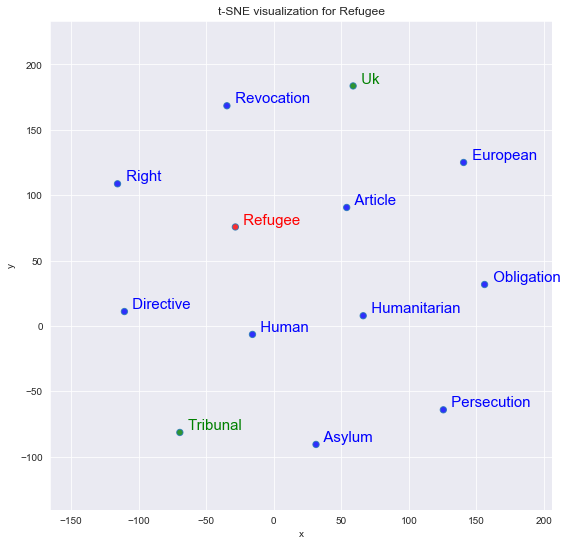

In [48]:
model_judgements = Word2Vec.load('./output/gensim-model-corpus_judgements')

tsnescatterplot(model_judgements, 'refugee', ['uk', 'tribunal'])


# 3. Topic model with Latent Dirichlet Allocation (LDA) and Latent Semantic Indexing (LSI)

The objective of topic models is to extract the underlying topics from a collection of text documents. Each document in the text is considered as a combination of topics and each topic is considered as a combination of related words.

Topic modeling can be done by algorithms like Latent Dirichlet Allocation (LDA) and Latent Semantic Indexing (LSI).

3.1. Latent Dirichlet Allocation (LDA)
Each document can be described by a distribution of topics and each topic can be described by a distribution of words. https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158

In [ ]:
from gensim.models import LdaModel, LdaMulticore

In [ ]:
# Starting from corpus_clean

# Build the bigram and trigram models
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus_clean], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



In [ ]:
# See trigram example
#print(trigram_mod[bigram_mod[corpus_clean[0]]])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Remove Stop Words
data_words_nostops = remove_stopwords(corpus_clean)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])



In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corp = [id2word.doc2bow(text) for text in texts]

# View
print(corp[:1])

In [ ]:
id2word[0]

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corp[:1]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corp,
                                           id2word = id2word,
                                           num_topics = 5, 
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)

In [ ]:


# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corp]

In [ ]:
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corp))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corp, id2word)
vis

Building LDA Mallet Model

In [ ]:
# Building LDA Mallet Model
from gensim.models.wrappers import LdaMallet

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './data/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corp, num_topics = 5, id2word = id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

Optimal number of topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

What topic each document?

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corp, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Most representative document for each topic

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics